# Donor Choose : RF and GBDT

In [1]:
import os

os.chdir('E:\Datasets\DonorChoose')

In [2]:
import pandas as pd

donor = pd.read_csv('cleandonor4.csv')

donor.head(2)

,teacher_prefix,school_state,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategory,cleanEssay,price,quantity,cleanProjectGradeCategory,project_title
0,Mrs.,IN,0,0,Literacy-Language,ESL Literacy,My students are English learners that are work...,154.6,23,PreK-Two,Educational Support for English Learners at Home
1,Mr.,FL,7,1,History-Civics Health-Sports,Civics-Government TeamSports,Our students arrive to our school eager to lea...,299.0,1,Six-Eight,Wanted: Projector for Hungry Learners


In [3]:
# We are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [4]:
from tqdm import tqdm
ftitle = [] 

for sen in tqdm( donor['project_title'].values ): 
    strY = " "

    for w in sen.lower().split():
        if w not in stopwords:
            strY = strY + w + " "

    ftitle.append( strY.strip() )

100%|███████████████████████████████████████████████████████████████████████| 109248/109248 [00:01<00:00, 71614.07it/s]


In [5]:
donor.drop(['project_title'], axis=1, inplace=True)
donor['cleanTitle'] = ftitle

### Handling Missing data

In [6]:
nan = donor[ donor['teacher_prefix'].isnull() ]
nan

,teacher_prefix,school_state,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategory,cleanEssay,price,quantity,cleanProjectGradeCategory,cleanTitle


In [7]:
donor = donor[0 : 50000]

In [8]:
donor.shape

(50000, 11)

In [9]:
Y = donor['project_is_approved']

In [10]:
#donor.drop(['project_is_approved'], axis = 1, inplace = True)

In [11]:
X = donor

## Splitting data

In [12]:
from sklearn.model_selection import train_test_split

xtrain, xtest, ytrain, ytest = train_test_split( X, Y, test_size = 0.33, stratify = Y) # Spliting into Test and Train

# stratify : we need to pass array containing class label as an argument to stratify

xtrain, xcv, ytrain, ycv = train_test_split( xtrain, ytrain, test_size = 0.33, stratify = ytrain )

In [13]:
print( xtrain.shape )
print( xcv.shape )
print( xtest.shape )

print( ytrain.shape )
print( ycv.shape )
print( ytest.shape )

(22445, 11)
(11055, 11)
(16500, 11)
(22445,)
(11055,)
(16500,)


## Creating data matrix

### Essay BOW

In [14]:
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer( min_df = 10, ngram_range=(1,2), max_features = 5000 )
# ngram_range : The lower and upper boundary of the range of n-values for different n-grams to be extracted.
# max_features : build a vocabulary that only consider the top max_features ordered by term frequency across the corpus.

vect.fit( xtrain['cleanEssay'].values )
# vect.fit( text ): Means that internally it is only learning the vocabulary of `Text` i.e. unique n-grams

# THE VOCABULARY SHOULD BUILT ONLY WITH THE WORDS OF TRAIN DATA

xtrEssayBOW = vect.transform( xtrain['cleanEssay'].values ) 
xcvEssayBOW = vect.transform( xcv['cleanEssay'].values ) 
xteEssayBOW = vect.transform( xtest['cleanEssay'].values )

In [15]:
print( xtrEssayBOW.shape )
print( xcvEssayBOW.shape )
print( xteEssayBOW.shape )

(22445, 5000)
(11055, 5000)
(16500, 5000)


### Essay TFIDF

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

tfidfvect = TfidfVectorizer( min_df=10, max_features = 5000, ngram_range = (1,2) )
tfidfvect.fit( xtrain['cleanEssay'].values )

xtrEssayTFIDF = tfidfvect.transform( xtrain['cleanEssay'].values )
xcvEssayTFIDF = tfidfvect.transform( xcv['cleanEssay'].values )
xteEssayTFIDF = tfidfvect.transform( xtest['cleanEssay'].values )

print( xtrEssayTFIDF.shape )
print( xcvEssayTFIDF.shape )
print( xteEssayTFIDF.shape )

(22445, 5000)
(11055, 5000)
(16500, 5000)


### Essay Word 2 vec

In [17]:
# Function Creating a list that contains all the words in the data column

def stow( data ):
    sentence = []

    for sen in tqdm( data.values ):
        fsentence = []
    
        for w in sen.split():
            for cw in w.split():
            
                if cw.isalpha():
                    fsentence.append( cw.lower() )
                else:
                    continue
        sentence.append( fsentence )
    return sentence

In [18]:
import gensim

In [19]:
xtrw = stow( xtrain['cleanEssay'] ) # List of words for xtrain

print( len( xtrw ) )

xtrmodel = gensim.models.Word2Vec( xtrw, min_count = 5, size =50, workers = 4 )
# min_count : If a word dosent apper more then the value assigned do't construct w2v for it
# size: dimension of vector to be constructed
# workers: If you hav a multi cores you can set it to 4 for performence

xtrwords = list( xtrmodel.wv.vocab )
len( xtrwords )

100%|██████████████████████████████████████████████████████████████████████████| 22445/22445 [00:05<00:00, 4397.58it/s]


22445


10807

In [20]:
# For Cross validation

xcvw = stow( xcv['cleanEssay'] )

print( len( xcvw ) )

xcvmodel = gensim.models.Word2Vec( xcvw, min_count = 5, size =50, workers = 4 )

xcvwords = list( xcvmodel.wv.vocab )
len( xcvwords )

100%|██████████████████████████████████████████████████████████████████████████| 11055/11055 [00:02<00:00, 4656.77it/s]


11055


8150

In [21]:
# For Test

xtew = stow( xtest['cleanEssay'] )

print( len( xtew ) )

xtemodel = gensim.models.Word2Vec( xtew, min_count = 5, size =50, workers = 4 )

xtewords = list( xtemodel.wv.vocab )
len( xtewords )

100%|██████████████████████████████████████████████████████████████████████████| 16500/16500 [00:03<00:00, 4421.50it/s]


16500


9572

### Essay Avg Word 2 vec

In [22]:
import numpy as np


def avgw2v( data, words, model ):
    sentV = [] # average word 2 vec for each essay is stored in this

    for sent in tqdm( data ):
    
        svec = np.zeros(50)
        cnw = 0
    
        for w in sent:
            if w in words:
                vec = model.wv[ w ]  # Computing word 2 vec
                svec += vec     # Add it to the svec
                cnw += 1
            
        if cnw != 0:        
            svec /= cnw  # Averaging with the count of number of words with valid vector in the Essay
        sentV.append( svec )
    
    return sentV

In [23]:
# For Train
xtrAW2V = np.asarray( avgw2v( xtrw, xtrwords, xtrmodel ) )

xtrAW2V[20]

xtrAW2V.shape

100%|███████████████████████████████████████████████████████████████████████████| 22445/22445 [02:22<00:00, 158.00it/s]


(22445, 50)

In [24]:
xcvAW2V = np.asarray( avgw2v( xcvw, xtrwords, xtrmodel ) )

xcvAW2V.shape

100%|███████████████████████████████████████████████████████████████████████████| 11055/11055 [01:10<00:00, 156.03it/s]


(11055, 50)

In [25]:
xteAW2V = np.asarray( avgw2v( xtew, xtrwords, xtrmodel ) )

xteAW2V.shape

100%|███████████████████████████████████████████████████████████████████████████| 16500/16500 [01:50<00:00, 149.70it/s]


(16500, 50)

### Essay TFIDF WW2V

In [26]:
print( tfidfvect.get_feature_names()[1000:1020] )
len( tfidfvect.get_feature_names() )

['comfortably', 'comfy', 'coming', 'coming from', 'coming to', 'committed', 'committed to', 'common', 'common core', 'communicate', 'communication', 'communication skills', 'communities', 'community', 'community and', 'community in', 'community is', 'community of', 'community that', 'community we']


5000

In [27]:
essayFeatures = tfidfvect.get_feature_names()  # Tf idf words/ col names

In [28]:
def ww2v( data, model, TFIDF, feat = essayFeatures ):
    
    essayWw2v = []  # the Tfidf weighted w2v for each sentence is stored here
    row = 0

    for sent in tqdm( data ):
        sv = np.zeros( 50 )  # as word vectors are of zero length
        ws = 0  # ws : weight sum, num of words with a valid vector in the sentence/review

        for w in sent:      

            try:
                vec = model.wv[ w ]
                tfidf = TFIDF[ row, feat.index( w ) ]

                sv += ( vec * tfidf )
                ws += tfidf

            except:
                pass

        if ws != 0:
            sv /= ws
        essayWw2v.append( sv )
        row += 1

    return essayWw2v

In [29]:
# For train
xtrWW2V = np.asarray( ww2v( xtrw, xtrmodel, xtrEssayTFIDF ) )

xtrWW2V.shape

100%|████████████████████████████████████████████████████████████████████████████| 22445/22445 [11:40<00:00, 32.03it/s]


(22445, 50)

In [30]:
xcvWW2V = np.asarray( ww2v( xcvw, xtrmodel, xcvEssayTFIDF ) )

xcvWW2V.shape

100%|████████████████████████████████████████████████████████████████████████████| 11055/11055 [05:33<00:00, 33.16it/s]


(11055, 50)

In [31]:
xteWW2V = np.asarray( ww2v( xtew, xtrmodel, xteEssayTFIDF ) )

xteWW2V.shape

100%|████████████████████████████████████████████████████████████████████████████| 16500/16500 [08:24<00:00, 32.68it/s]


(16500, 50)

### Project Title BOW

In [32]:
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer( min_df = 10, ngram_range = (1,2), max_features = 5000 )

vect.fit( xtrain['cleanTitle'].values )

xtrTitleBOW = vect.transform( xtrain['cleanTitle'].values )
xcvTitleBOW = vect.transform( xcv['cleanTitle'].values )
xteTitleBOW = vect.transform( xtest['cleanTitle'].values )

print( xtrTitleBOW.shape )
print( xcvTitleBOW.shape )
print( xteTitleBOW.shape )

(22445, 1636)
(11055, 1636)
(16500, 1636)


### Project title TFIDF

In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

tfidfvect = TfidfVectorizer( min_df=10, ngram_range = (1,2), max_features = 5000 )
tfidfvect.fit( xtrain['cleanTitle'].values )

xtrTitleTFIDF = tfidfvect.transform( xtrain['cleanTitle'].values )
xcvTitleTFIDF = tfidfvect.transform( xcv['cleanTitle'].values )
xteTitleTFIDF = tfidfvect.transform( xtest['cleanTitle'].values )

print( xtrTitleTFIDF.shape )
print( xcvTitleTFIDF.shape )
print( xteTitleTFIDF.shape )

(22445, 1636)
(11055, 1636)
(16500, 1636)


### Project Title Word 2 Vec

In [34]:
# For Train

xtrTitlew = stow( xtrain['cleanTitle'] )  # stow : is a defined by me that coverts a list of sentences to words

print( len( xtrTitlew ) )

xtrTitlemodel = gensim.models.Word2Vec( xtrTitlew, min_count = 5, size =50, workers = 4 )

xtrTitlewords = list( xtrTitlemodel.wv.vocab )
len( xtrTitlewords )

100%|████████████████████████████████████████████████████████████████████████| 22445/22445 [00:00<00:00, 207244.79it/s]


22445


1693

In [35]:
# For Cross Validation

xcvTitlew = stow( xcv['cleanTitle'] )

print( len( xcvTitlew ) )

xcvTitlemodel = gensim.models.Word2Vec( xcvTitlew, min_count = 5, size =50, workers = 4 )

xcvTitlewords = list( xcvTitlemodel.wv.vocab )
len( xcvTitlewords )

100%|████████████████████████████████████████████████████████████████████████| 11055/11055 [00:00<00:00, 174092.07it/s]


11055


1021

In [36]:
# For Test

xteTitlew = stow( xtest['cleanTitle'] )

print( len( xteTitlew ) )

xteTitlemodel = gensim.models.Word2Vec( xteTitlew, min_count = 5, size =50, workers = 4 )

xteTitlewords = list( xteTitlemodel.wv.vocab )
len( xteTitlewords )

100%|█████████████████████████████████████████████████████████████████████████| 16500/16500 [00:00<00:00, 37052.33it/s]


16500


1328

### Project title Avg Word 2 vec

In [37]:
# For Train

xtrTitleAW2V = np.asarray( avgw2v( xtrTitlew, xtrTitlewords, xtrTitlemodel ) )

xtrTitleAW2V.shape

100%|█████████████████████████████████████████████████████████████████████████| 22445/22445 [00:01<00:00, 16040.57it/s]


(22445, 50)

In [38]:
# For Cross validation

xcvTitleAW2V = np.asarray( avgw2v( xcvTitlew, xtrTitlewords, xtrTitlemodel ) )

xcvTitleAW2V.shape

100%|█████████████████████████████████████████████████████████████████████████| 11055/11055 [00:00<00:00, 14460.59it/s]


(11055, 50)

In [39]:
# For Test

xteTitleAW2V = np.asarray( avgw2v( xteTitlew, xtrTitlewords, xtrTitlemodel ) )

xteTitleAW2V.shape

100%|█████████████████████████████████████████████████████████████████████████| 16500/16500 [00:01<00:00, 15025.57it/s]


(16500, 50)

### Project title TFIDF WW2V

In [40]:
print( tfidfvect.get_feature_names()[0:30] )
len( tfidfvect.get_feature_names() )

['05', '10', '101', '16', '1st', '1st grade', '1st graders', '2016', '2017', '21st', '21st century', '2nd', '2nd grade', '2nd graders', '3d', '3d printer', '3d printing', '3rd', '3rd grade', '3rd graders', '4th', '4th grade', '4th graders', '5th', '5th grade', '5th graders', '6th', '6th grade', '8th', 'academic']


1636

In [41]:
titlefeatures = tfidfvect.get_feature_names()

In [42]:
# For train
xtrTitleWW2V = np.asarray( ww2v( xtrTitlew, xtrTitlemodel, xtrTitleTFIDF, titlefeatures ) )

xtrTitleWW2V.shape

100%|██████████████████████████████████████████████████████████████████████████| 22445/22445 [00:04<00:00, 4513.14it/s]


(22445, 50)

In [43]:
# For Cross validation
xcvTitleWW2V = np.asarray( ww2v( xcvTitlew, xtrTitlemodel, xcvTitleTFIDF, titlefeatures ) )

xcvTitleWW2V.shape

100%|██████████████████████████████████████████████████████████████████████████| 11055/11055 [00:02<00:00, 4653.51it/s]


(11055, 50)

In [44]:
# For Test
xteTitleWW2V = np.asarray( ww2v( xteTitlew, xtrTitlemodel, xteTitleTFIDF, titlefeatures ) )

xteTitleWW2V.shape

100%|██████████████████████████████████████████████████████████████████████████| 16500/16500 [00:03<00:00, 4890.37it/s]


(16500, 50)

## Function for Response Coding of Categorical Features

The response tabel is built only on train dataset. For a category which is not there in train data and present in test data, we will encode them with default values Ex: in our test data if have State: D then we encode it as [0.5, 0.05]

In [45]:
def feaDic( alpha, feature, df ):
    
    count = xtrain[ feature ].value_counts()
    
    # count :  CA    597        NY    306         TX    289       FL    231       NC    206
    
    featDict = dict()
    
    # denominator will contain the number of time that particular feature occured in whole data
    
    for i, denominator in count.items():   # Here i = CA and deno = 597
       
        vec = []
        
        for j in range(1,3):  # itearte 2 times

            cls_cnt = xtrain.loc[ ( xtrain['project_is_approved'] == j ) & ( xtrain[feature] == i ) ]
            # cls_cnt will return a type(xtr) that will contain Only single features belonging to a single class
            
            # cls_cnt.shape[0] will contain the number of time that particular feature occured in the whole data
            
            vec.append( ( cls_cnt.shape[0] + alpha * 10 ) / ( denominator + 90 * alpha ) )

        # we are adding the feature to the dict as key and vec as value
        featDict[i] = vec
    return featDict

# when we caculate the probability of a feature belongs to any particular class, we apply laplace smoothing
# (numerator + 10 *alpha) / (denominator + 90 *alpha ) 



def feature( alpha, feature, df ):
   
    featureDict = feaDic( alpha, feature, df ) # Function Call

    count = xtrain[feature].value_counts()
    
    # feat :it will contain the feature for each feature value in the data
    feat = []
    
  
    for index, row in df.iterrows():
        
        if row[feature] in dict( count ).keys():
            feat.append( featureDict[ row[feature] ] )
        else:
            feat.append([0.5, 0.05])

    return feat


### State

In [46]:
alpha = 1 # alpha is used for laplace smoothing

xtrStateRC = np.array( feature( alpha, "school_state", xtrain) )
xteStateRC = np.array( feature( alpha, "school_state", xtest) )
xcvStateRC = np.array( feature( alpha, "school_state", xcv) )

In [47]:
xtrStateRC[4]

array([0.47457627, 0.05649718])

In [48]:
xtrain.head(2)

,teacher_prefix,school_state,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategory,cleanEssay,price,quantity,cleanProjectGradeCategory,cleanTitle
1577,Mrs.,IL,1,1,History-Civics,SocialSciences,For this class the students are juniors and se...,25.27,7,Nine-Twelve,brain...
1026,Ms.,NC,10,1,Health-Sports,Gym-Fitness,"I teach over 800 kindergarten, 1st, 2nd and 3r...",49.83,29,PreK-Two,tps gets drumfit!


### Teacher Prefix

In [49]:
alpha = 1 # alpha is used for laplace smoothing

xtrPrefixRC = np.array( feature( alpha, "teacher_prefix", xtrain) )
xtePrefixRC = np.array( feature( alpha, "teacher_prefix", xtest) )
xcvPrefixRC = np.array( feature( alpha, "teacher_prefix", xcv) )

print( xtrPrefixRC.shape )
print( xcvPrefixRC.shape )
print( xtePrefixRC.shape )

(22445, 2)
(11055, 2)
(16500, 2)


### Category

In [50]:
alpha = 1 # alpha is used for laplace smoothing

xtrCatRC = np.array( feature( alpha, "clean_categories", xtrain) )
xteCatRC = np.array( feature( alpha, "clean_categories", xtest) )
xcvCatRC = np.array( feature( alpha, "clean_categories", xcv) )

print( xtrCatRC.shape )
print( xcvCatRC.shape )
print( xteCatRC.shape )

(22445, 2)
(11055, 2)
(16500, 2)


### Sub Category

In [51]:
alpha = 1 # alpha is used for laplace smoothing

xtrSubCatRC = np.array( feature( alpha, "clean_subcategory", xtrain) )
xteSubCatRC = np.array( feature( alpha, "clean_subcategory", xtest) )
xcvSubCatRC = np.array( feature( alpha, "clean_subcategory", xcv) )

print( xtrSubCatRC.shape )
print( xcvSubCatRC.shape )
print( xteSubCatRC.shape )

(22445, 2)
(11055, 2)
(16500, 2)


### Price

In [52]:
from sklearn.preprocessing import Normalizer

norm = Normalizer()

# norm.fit( xtrain['price'].values ) # gives error : Expected 2D array, got 1D array instead
norm.fit( xtrain['price'].values.reshape(-1,1) )

xtrPrice = norm.transform( xtrain['price'].values.reshape(-1,1) )
xcvPrice = norm.transform( xcv['price'].values.reshape(-1,1) )
xtePrice = norm.transform( xtest['price'].values.reshape(-1,1) )

print( xtrPrice.shape )
print( xcvPrice.shape )
print( xtePrice.shape )

(22445, 1)
(11055, 1)
(16500, 1)


### Previously Posted projects

In [53]:
from sklearn.preprocessing import Normalizer

norm = Normalizer()

# norm.fit( xtrain['price'].values ) # gives error : Expected 2D array, got 1D array instead
norm.fit( xtrain['teacher_number_of_previously_posted_projects'].values.reshape(-1,1) )

xtrPrev = norm.transform( xtrain['teacher_number_of_previously_posted_projects'].values.reshape(-1,1) )
xcvPrev = norm.transform( xcv['teacher_number_of_previously_posted_projects'].values.reshape(-1,1) )
xtePrev = norm.transform( xtest['teacher_number_of_previously_posted_projects'].values.reshape(-1,1) )

print( xtrPrev.shape )
print( xcvPrev.shape )
print( xtePrev.shape )

(22445, 1)
(11055, 1)
(16500, 1)


### Quantity

In [54]:
from sklearn.preprocessing import Normalizer

norm = Normalizer()

# norm.fit( xtrain['price'].values ) # gives error : Expected 2D array, got 1D array instead
norm.fit( xtrain['quantity'].values.reshape(-1,1) )

xtrQuan = norm.transform( xtrain['quantity'].values.reshape(-1,1) )
xcvQuan = norm.transform( xcv['quantity'].values.reshape(-1,1) )
xteQuan = norm.transform( xtest['quantity'].values.reshape(-1,1) )

print( xtrQuan.shape )
print( xcvQuan.shape )
print( xteQuan.shape )

(22445, 1)
(11055, 1)
(16500, 1)


### Merging Features

### Set 1

In [55]:
from scipy.sparse import hstack

xtr1 = hstack(( xtrEssayBOW, xtrTitleBOW, xtrStateRC, xtrPrefixRC, xtrCatRC, xtrSubCatRC, xtrPrice, xtrQuan, xtrPrev )).tocsr()
xcv1 = hstack(( xcvEssayBOW, xcvTitleBOW, xcvStateRC, xcvPrefixRC, xcvCatRC, xcvSubCatRC, xcvPrice, xcvQuan, xcvPrev )).tocsr()
xte1 = hstack(( xteEssayBOW, xteTitleBOW, xteStateRC, xtePrefixRC, xteCatRC, xteSubCatRC, xtePrice, xteQuan, xtePrev )).tocsr()

print( xtr1.shape, ytrain.shape )
print( xcv1.shape, ycv.shape )
print( xte1.shape, ytest.shape )

(22445, 6647) (22445,)
(11055, 6647) (11055,)
(16500, 6647) (16500,)


### Set 2

In [56]:
from scipy.sparse import hstack

xtr2 = hstack(( xtrEssayTFIDF, xtrTitleTFIDF, xtrStateRC, xtrPrefixRC, xtrCatRC, xtrSubCatRC, xtrPrice, xtrQuan, xtrPrev)).tocsr()
xcv2 = hstack(( xcvEssayTFIDF, xcvTitleTFIDF, xcvStateRC, xcvPrefixRC, xcvCatRC, xcvSubCatRC, xcvPrice, xcvQuan, xcvPrev )).tocsr()
xte2 = hstack(( xteEssayTFIDF, xteTitleTFIDF, xteStateRC, xtePrefixRC, xteCatRC, xteSubCatRC, xtePrice, xteQuan, xtePrev )).tocsr()

print( xtr2.shape, ytrain.shape )
print( xcv2.shape, ycv.shape )
print( xte2.shape, ytest.shape )

(22445, 6647) (22445,)
(11055, 6647) (11055,)
(16500, 6647) (16500,)


### Set 3

In [57]:
from scipy.sparse import hstack
import numpy as np

xtr3 = np.hstack(( xtrAW2V, xtrTitleAW2V, xtrStateRC, xtrPrefixRC, xtrCatRC, xtrSubCatRC, xtrPrice, xtrQuan, xtrPrev ))
xcv3 = np.hstack(( xcvAW2V, xcvTitleAW2V, xcvStateRC, xcvPrefixRC, xcvCatRC, xcvSubCatRC, xcvPrice, xcvQuan, xcvPrev ))
xte3 = np.hstack(( xteAW2V, xteTitleAW2V, xteStateRC, xtePrefixRC, xteCatRC, xteSubCatRC, xtePrice, xteQuan, xtePrev ))

print( xtr3.shape, ytrain.shape )
print( xcv3.shape, ycv.shape )
print( xte3.shape, ytest.shape )

(22445, 111) (22445,)
(11055, 111) (11055,)
(16500, 111) (16500,)


### Set 4

In [58]:
from scipy.sparse import hstack
import numpy as np

xtr4 = np.hstack(( xtrWW2V, xtrTitleWW2V, xtrStateRC, xtrPrefixRC, xtrCatRC, xtrSubCatRC, xtrPrice, xtrQuan, xtrPrev ))
xcv4 = np.hstack(( xcvWW2V, xcvTitleWW2V, xcvStateRC, xcvPrefixRC, xcvCatRC, xcvSubCatRC, xcvPrice, xcvQuan, xcvPrev ))
xte4 = np.hstack(( xteWW2V, xteTitleWW2V, xteStateRC, xtePrefixRC, xteCatRC, xteSubCatRC, xtePrice, xteQuan, xtePrev ))

print( xtr4.shape, ytrain.shape )
print( xcv4.shape, ycv.shape )
print( xte4.shape, ytest.shape )

(22445, 111) (22445,)
(11055, 111) (11055,)
(16500, 111) (16500,)


In [59]:
import plotly
import plotly.graph_objs as go

plotly.offline.init_notebook_mode(connected=True)

plotly.offline.iplot({
    "data": [go.Scatter(x=[1, 2, 3, 4], y=[4, 3, 2, 1])],
    "layout": go.Layout(title="hello world")
})

# Ref : https://plot.ly/python/

## Functions

In [71]:
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix

import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()

import seaborn as sn

D:\Anaconda\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning:

numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [64]:
def batchPredict( data, classifier ): # Predict the probablity of data points in batch i.e; some data points at once 
    
    yPred = []
    
    loop = data.shape[0] - data.shape[0] % 1000   # data.shape[0] : no of rows in data matrix
    # for ex data shape = 4489 then loop = 4489 - 4489%1000 = 4489 - 489 = 4000 
    # Now we can divide our loop into 4 interval of 1000s and one remaining 489
    # ie; 1-1000 in 1st iteration 1000-2000 in 2nd iteration 2000-3000 in 3rd 3000-4000 in 4th and 4000-4489 in the last iteraion
    
    for i in range( 0, loop, 1000 ):
        # If loop = 4000 Computes proba for 0 - 4000 in 4 iterations
       
        yPred.extend( classifier.predict_proba( data[i : i+1000] )[ :, 1] ) # [ :, 1] : All row Only 1 col
        # predict_proba : Return probability estimates for the test data X.

    yPred.extend( classifier.predict_proba( data[ loop : ] )[ :, 1 ] )
    # computes probab for remaining points

    return yPred

In [65]:
def BestDE( xtr, xcv, ytr, ycv ):
    
    trAUC = []
    cvAUC = []
    
    depth = [ 5, 11, 51, 101 ]
    estimator = [10, 50, 100, 200]
    d = []
    e = []
    print(' '*12,'- First -', ' '*16,'- Second -', ' '*17,'- Third -', ' '*16,'- Fourth -')
    print('      ', end =' ')

    for i in depth:
        for j in estimator:
            
            clf = RandomForestClassifier( max_depth = i, n_estimators = j, class_weight = 'balanced', n_jobs=-1 )
            clf.fit( xtr, ytr )
            
            ytrPred = batchPredict( xtr, clf )    
            ycvPred = batchPredict( xcv, clf )

            # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
            # not the predicted outputs 

            trAUC.append( roc_auc_score( ytr, ytrPred ))
            cvAUC.append( roc_auc_score( ycv, ycvPred ))
            d.append(i)
            e.append(j)
        print('#'*20, end ='        ')
    
    # d = [ 5,   5,  5,   5,    11, 11,  11, 11,     51, 51,  51,  51,    101, 101, 101, 101 ]
    # e = [ 10, 50, 100, 200,   10, 50, 100, 200,    10, 50, 100, 200,    10,  50, 100, 200 ]

    trace1 = go.Scatter3d( x = d, y = e , z = trAUC, name = 'Train')
    trace2 = go.Scatter3d( x = d, y = e, z = cvAUC, name = 'Cross validation')

    data = [trace1, trace2]

    layout = go.Layout(scene = dict(
        xaxis = dict(title='max_depth'),
        yaxis = dict(title='n_estimators'),
        zaxis = dict(title='AUC'),))

    fig = go.Figure(data=data, layout=layout)
    offline.iplot(fig, filename='3d-scatter-colorscale')

## To Calculate and Plot CM

In [66]:
def predictCM( probab, threshold, fpr, tpr ):
    
    t = threshold[ np.argmax( fpr*( 1 - tpr ) ) ]  # returns the threshold val for the point with max fpr(1-tpr) value
    # fpr*( 1 - tpr ) will be high if fpr is high and tpr is low
    # argmax : Returns the indices of the maximum val along an axis
    
    print(" The maximum value of tpr*(1-fpr) = ", max( tpr*(1-fpr) ), " for threshold = ", np.round(t,3))
    
    pred = []
    for i in probab: # i = Probability for all data points
        
        if i >= t:   #  if Probablity of a point is >= the Threshold value i,e; Threshold at index of max val of fpr(1-tpr) 
            pred.append(1)
        else:
            pred.append(0)
            
    return pred

In [67]:
def cm( ytr, yte, yTrainPred, trThreshold, trFPR, trTPR, yTestPred, teThreshold, teFPR, teTPR, sno ):
    
    print("Confusion Matrix for Train of Set ", sno)
    
    predicted = predictCM( yTrainPred, trThreshold, trFPR, trTPR )
    cmtr = confusion_matrix( ytr, predicted )
    print( cmtr  )

    plt.figure(figsize = (8,6))
    sn.set(font_scale=1.4) #for label size
    sn.heatmap(cmtr, fmt=".1f", annot=True, annot_kws={"size": 18}, cmap='Blues_r')# font size
    plt.ylabel('True label', size=18)
    plt.xlabel('Predicted label', size=18)
    plt.show()
    plt.close()



    print("\n\nConfusion Matrix for Test ", sno)
    predicted = predictCM( yTestPred, teThreshold, teFPR, teTPR )

    cmte = confusion_matrix( yte, predicted )
    print( cmte )

    plt.figure(figsize = (8,6))
    sn.set(font_scale=1.4) #for label size
    sn.heatmap(cmte, fmt=".1f", annot=True, annot_kws={"size": 18}, cmap='Blues_r')# font size
    plt.ylabel('True label', size=18)
    plt.xlabel('Predicted label', size=18)
    plt.show()
    plt.close()

In [68]:
def Predict( data, classifier ): # Predicts the probability of data points all at once
    
    yPred = []
        
    yPred.extend( classifier.predict_proba( data )[:, 1] ) # [ :, 1] : All row Only 1 col
    # predict_proba : Return probability estimates for the test data X.
    
    return yPred

In [69]:
def roc( xtr, xte, ytr, yte, D, N, sno ):
    
    clf = RandomForestClassifier( n_estimators = N, max_depth = D, class_weight = 'balanced' )
    clf.fit( xtr, ytr )

    yTrainPred = Predict( xtr, clf )    
    yTestPred = Predict( xte, clf )

    trFPR, trTPR, trThreshold = roc_curve( ytr, yTrainPred ) # ytrain and YTrainPred must have same no. of points
    teFPR, teTPR, teThreshold = roc_curve( yte, yTestPred )

    # roc_curve() : Compute Receiver operating characteristic (ROC),
    # this implementation is restricted to the binary classification task.
    # roc_curve( yTrue, yScore ) : yTrue = True Binary labels, yScore = Target values Probablistic estimate, confidence values etc
    # The func returns 3 arrays : fpr = false Positive rates, tpr = True Positive rates, Threshold 

    plt.figure( figsize = (15, 5) )
    plt.plot( trFPR, trTPR, label="Train AUC = " + str( auc( trFPR, trTPR ) ) )
    plt.plot( teFPR, teTPR, label="Test AUC = " + str( auc( teFPR, teTPR ) ) )

    plt.legend()
    plt.xlabel(" Hyperparameter ")
    plt.ylabel(" AUC ")
    plt.title("ERROR PLOTS for Set "+str(sno))
    plt.grid()
    plt.show()
    
    
    cm( ytr, yte, yTrainPred, trThreshold, trFPR, trTPR, yTestPred, teThreshold, teFPR, teTPR, sno )
    


# Random Forest

## Operations on Set 1

In [72]:
BestDE( xtr1, xcv1, ytrain, ycv )

             - First -                  - Second -                   - Third -                  - Fourth -
       ####################        ####################        ####################        ####################        

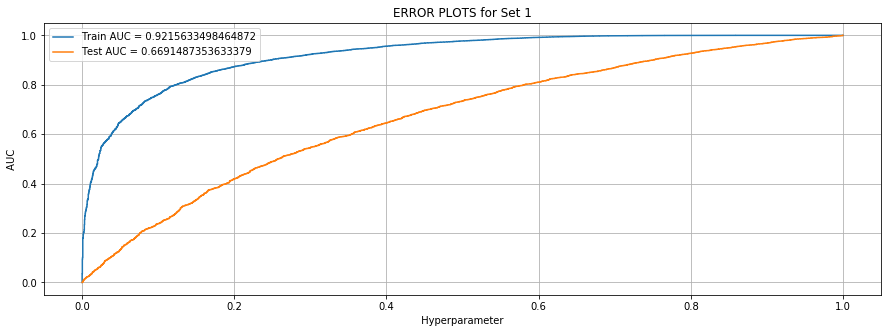

Confusion Matrix for Train of Set  1
 The maximum value of tpr*(1-fpr) =  0.7072782266817937  for threshold =  0.838
[[ 2906   557]
 [ 3038 15944]]


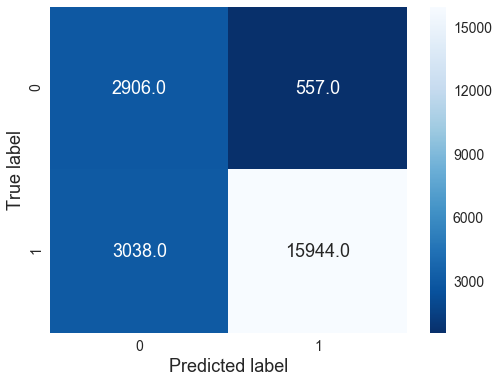



Confusion Matrix for Test  1
 The maximum value of tpr*(1-fpr) =  0.3904648659871212  for threshold =  0.846
[[1651  895]
 [5643 8311]]


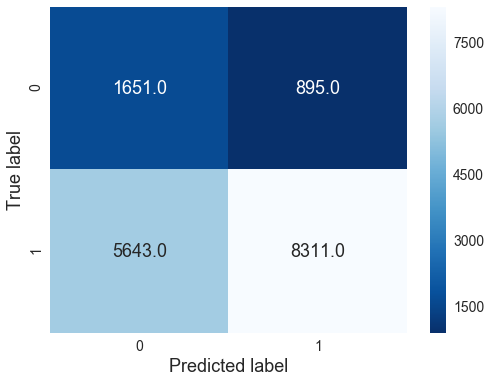

In [76]:
bestD = 11
bestN = 200

roc( xtr1, xte1, ytrain, ytest, bestD, bestN, 1 )

## Opeartions on Set 2

In [73]:
BestDE( xtr2, xcv2, ytrain, ycv )

             - First -                  - Second -                   - Third -                  - Fourth -
       ####################        ####################        ####################        ####################        

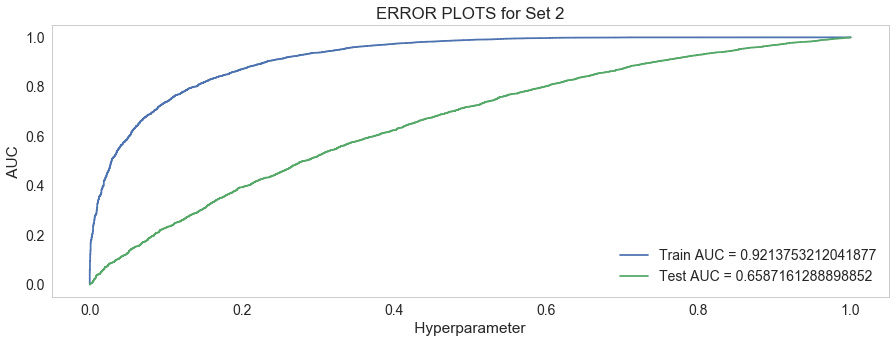

Confusion Matrix for Train of Set  2
 The maximum value of tpr*(1-fpr) =  0.6992772428477845  for threshold =  0.844
[[ 2974   489]
 [ 3757 15225]]


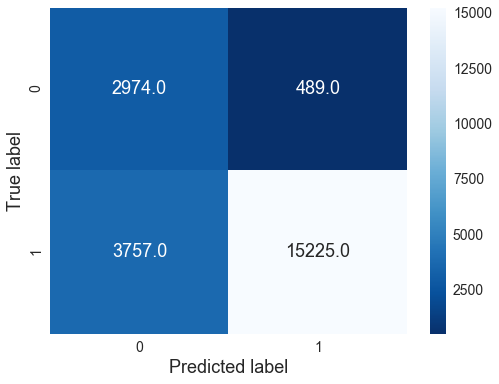



Confusion Matrix for Test  2
 The maximum value of tpr*(1-fpr) =  0.3775503080990722  for threshold =  0.847
[[1521 1025]
 [5220 8734]]


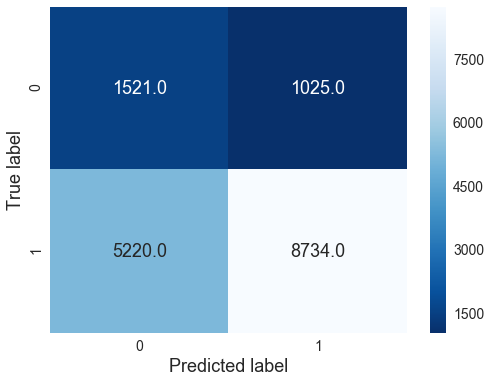

In [78]:
bestD = 11
bestN = 200
sn.set_style('whitegrid')

roc( xtr2, xte2, ytrain, ytest, bestD, bestN, 2 )

## Opeartions on Set 3

In [74]:
BestDE( xtr3, xcv3, ytrain, ycv )

             - First -                  - Second -                   - Third -                  - Fourth -
       ####################        ####################        ####################        ####################        

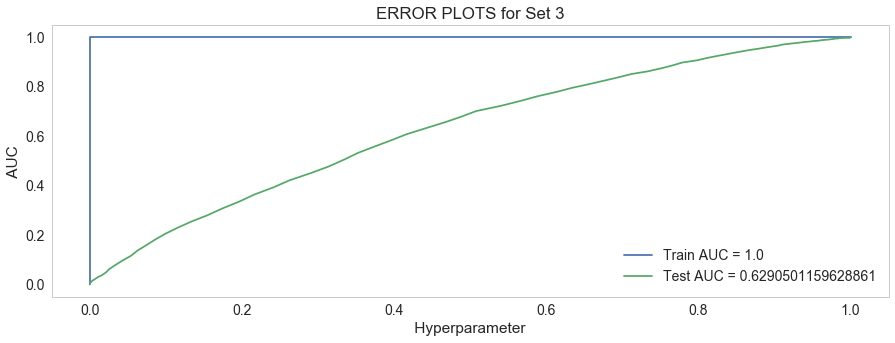

Confusion Matrix for Train of Set  3
 The maximum value of tpr*(1-fpr) =  1.0  for threshold =  1.0
[[ 3463     0]
 [18963    19]]


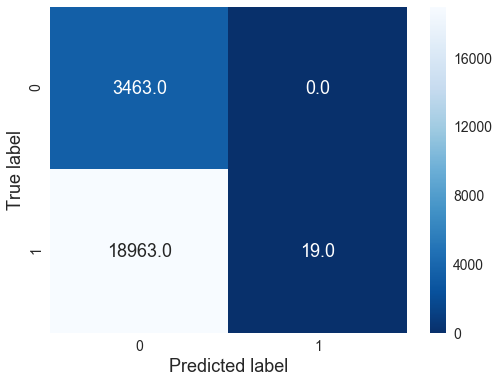



Confusion Matrix for Test  3
 The maximum value of tpr*(1-fpr) =  0.35482250568330165  for threshold =  0.845
[[1691  855]
 [6873 7081]]


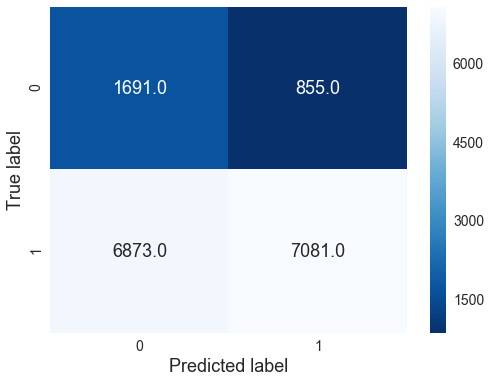

In [79]:
bestD = 101
bestN = 200
sn.set_style('whitegrid')

roc( xtr3, xte3, ytrain, ytest, bestD, bestN, 3 )

## Operations on Set 4

In [75]:
BestDE(xtr4, xcv4, ytrain, ycv)

             - First -                  - Second -                   - Third -                  - Fourth -
       ####################        ####################        ####################        ####################        

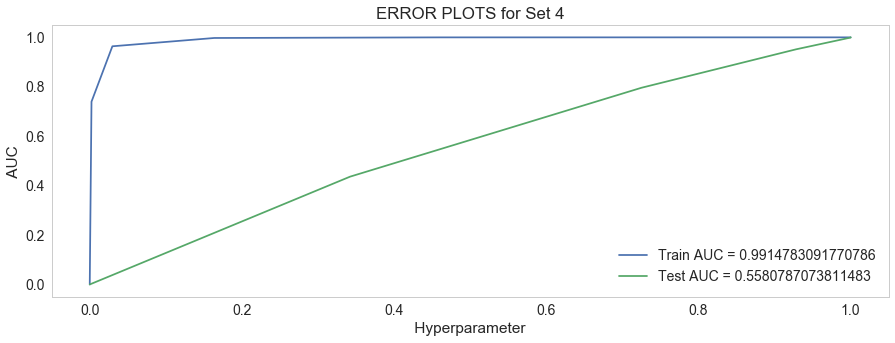

Confusion Matrix for Train of Set  4
 The maximum value of tpr*(1-fpr) =  0.9351923990912193  for threshold =  0.8
[[ 3360   103]
 [  686 18296]]


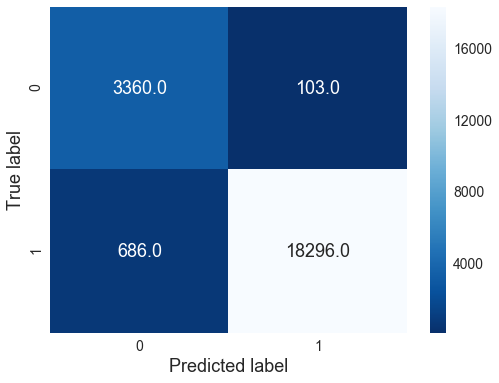



Confusion Matrix for Test  4
 The maximum value of tpr*(1-fpr) =  0.2869861876994335  for threshold =  1.0
[[1675  871]
 [7867 6087]]


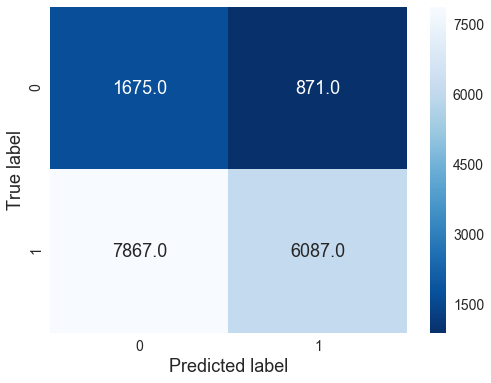

In [80]:
bestN = 5
bestD = 100
sn.set_style('whitegrid')

roc( xtr4, xte4, ytrain, ytest, bestD, bestN, 4 )

In [94]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = [" Classifier "," Set "," Vectorizer ", " Best Depth ", " Best Estimator ", " Train AUC ", " Test AUC "]

x.add_row( [ " Random Forest ", " Set 1 ", " B.O.W ", " 11 ", " 200 ", " 0.9215 ", " 0.6691 " ] ) 
x.add_row( [ " Random Forest ", " Set 2 ", " TFIDF ", " 11 ", " 200 ", " 0.9213 ", " 0.6587 " ] )
x.add_row( [ " Random Forest ", " Set 3 ", " Avg W2V ", " 101 ", " 100 ", " 1.0 ", " 0.6290 " ] )
x.add_row( [ " Random Forest ", " Set 4 ", " WW2V ", " 5 ", " 100 ", " 0.9914 ", " 0.5580 " ] )


print('\n\t\t\t Results of Random Forest Models')
print( x )

# Ref : http://zetcode.com/python/prettytable/


			 Results of Random Forest Models
+-----------------+---------+--------------+--------------+------------------+-------------+------------+
|    Classifier   |   Set   |  Vectorizer  |  Best Depth  |  Best Estimator  |  Train AUC  |  Test AUC  |
+-----------------+---------+--------------+--------------+------------------+-------------+------------+
|  Random Forest  |  Set 1  |    B.O.W     |      11      |       200        |    0.9215   |   0.6691   |
|  Random Forest  |  Set 2  |    TFIDF     |      11      |       200        |    0.9213   |   0.6587   |
|  Random Forest  |  Set 3  |   Avg W2V    |     101      |       100        |     1.0     |   0.6290   |
|  Random Forest  |  Set 4  |     WW2V     |      5       |       100        |    0.9914   |   0.5580   |
+-----------------+---------+--------------+--------------+------------------+-------------+------------+


## Observations

Avg Word 2 Vec gives maximum Train AUC

Amongst all the models B.O.W on set 2 gives maximum Test AUC

## XG Boost

## Function to find best depth and eta

In [81]:
import xgboost as xgb

def BestGB( xtr, xcv, ytr, ycv ):
    
    trAUC = []
    cvAUC = []
    
    depth = [ 5, 11, 51, 101 ]
    rate = [ 0.01, 0.1 , 1  ]
    d = []
    r = []
    print(' '*12,'- First -', ' '*16,'- Second -', ' '*17,'- Third -', ' '*16,'- Fourth -')
    print('      ', end =' ')

    for i in depth:
        for j in rate:
            
            clf = xgb.XGBClassifier( objective = "binary:logistic", random_state = 42, max_depth = i, eta = j, class_weight='balanced' )
            clf.fit( xtr, ytr )
            
            ytrPred = batchPredict( xtr, clf )    
            ycvPred = batchPredict( xcv, clf )

            # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
            # not the predicted outputs 

            trAUC.append( roc_auc_score( ytr, ytrPred ))
            cvAUC.append( roc_auc_score( ycv, ycvPred ))
            d.append(i)
            r.append(j)
        print('#'*20, end ='        ')
    
    #d = [ 5,   5,  5,   5,    11, 11,  11, 11,     51, 51,  51,  51,    101, 101, 101, 101 ]
    #e = [ 10, 50, 100, 200,   10, 50, 100, 200,    10, 50, 100, 200,    10,  50, 100, 200 ]

    trace1 = go.Scatter3d( x = d, y = r , z = trAUC, name = 'Train')
    trace2 = go.Scatter3d( x = d, y = r, z = cvAUC, name = 'Cross validation')

    data = [trace1, trace2]

    layout = go.Layout(scene = dict(
        xaxis = dict(title='max_depth'),
        yaxis = dict(title='learning_rate'),
        zaxis = dict(title='AUC'),))

    fig = go.Figure(data=data, layout=layout)
    offline.iplot(fig, filename='3d-scatter-colorscale')

In [84]:
def rocGB( xtr, xte, ytr, yte, D, N, sno ):
    
    clf = xgb.XGBClassifier( objective = "binary:logistic", random_state=42, max_depth = D, eta = N, class_weight='balanced' )
    clf.fit( xtr, ytr )

    yTrainPred = batchPredict( xtr, clf )    
    yTestPred = batchPredict( xte, clf )

    trFPR, trTPR, trThreshold = roc_curve( ytr, yTrainPred ) # ytrain and YTrainPred must have same no. of points
    teFPR, teTPR, teThreshold = roc_curve( yte, yTestPred )

    # roc_curve() : Compute Receiver operating characteristic (ROC),
    # this implementation is restricted to the binary classification task.
    # roc_curve( yTrue, yScore ) : yTrue = True Binary labels, yScore = Target values Probablistic estimate, confidence values etc
    # The func returns 3 arrays : fpr = false Positive rates, tpr = True Positive rates, Threshold 

    plt.figure( figsize = (15, 5) )
    plt.plot( trFPR, trTPR, label="Train AUC = " + str( auc( trFPR, trTPR ) ) )
    plt.plot( teFPR, teTPR, label="Test AUC = " + str( auc( teFPR, teTPR ) ) )

    plt.legend()
    plt.xlabel(" Hyperparameter ")
    plt.ylabel(" AUC ")
    plt.title("ERROR PLOTS for Set "+str(sno))
    plt.grid()
    plt.show()
    
    
    cm( ytr, yte, yTrainPred, trThreshold, trFPR, trTPR, yTestPred, teThreshold, teFPR, teTPR, sno )
    


## Operations on Set 1

In [83]:
BestGB( xtr1, xcv1, ytrain, ycv )

             - First -                  - Second -                   - Third -                  - Fourth -
       ####################        ####################        ####################        ####################        

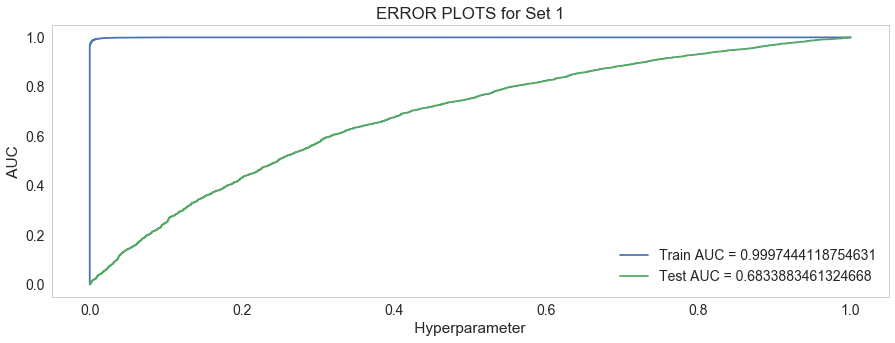

Confusion Matrix for Train of Set  1
 The maximum value of tpr*(1-fpr) =  0.9853447494507693  for threshold =  0.749
[[ 3420    43]
 [  103 18879]]


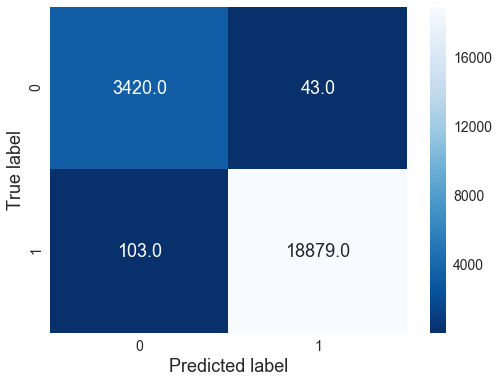



Confusion Matrix for Test  1
 The maximum value of tpr*(1-fpr) =  0.4139541199278834  for threshold =  0.869
[[1574  972]
 [4796 9158]]


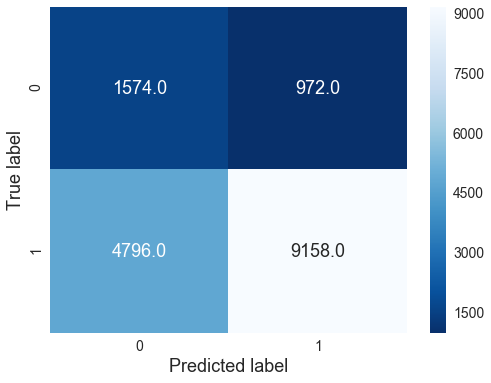

In [90]:
bestD = 11
bestN = 0.01

sn.set_style('whitegrid')

rocGB( xtr1, xte1, ytrain, ytest, bestD, bestN, 1 )

## Opeartions on Set 2

In [86]:
BestGB( xtr2, xcv2, ytrain, ycv )

             - First -                  - Second -                   - Third -                  - Fourth -
       ####################        ####################        ####################        ####################        

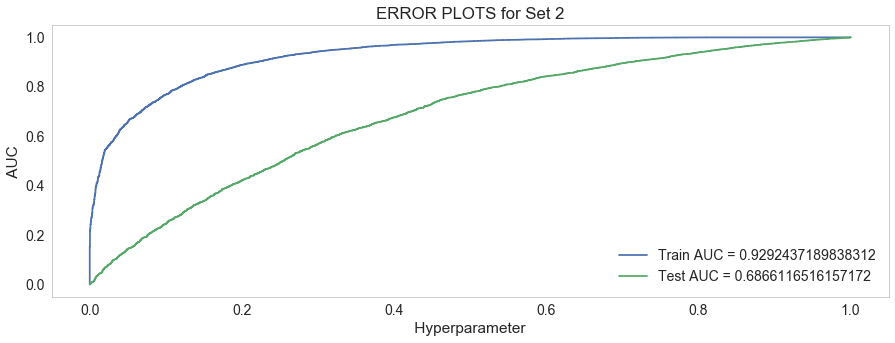

Confusion Matrix for Train of Set  2
 The maximum value of tpr*(1-fpr) =  0.7184264692240163  for threshold =  0.818
[[ 2944   519]
 [ 3045 15937]]


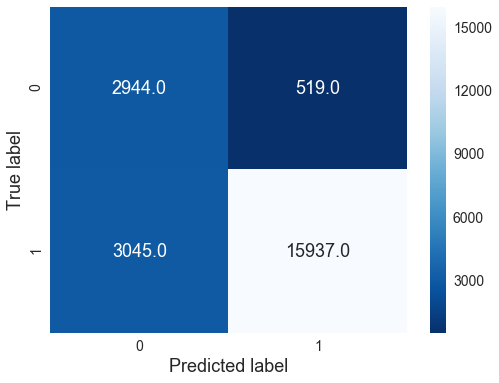



Confusion Matrix for Test  2
 The maximum value of tpr*(1-fpr) =  0.4094643932183864  for threshold =  0.844
[[1611  935]
 [5001 8953]]


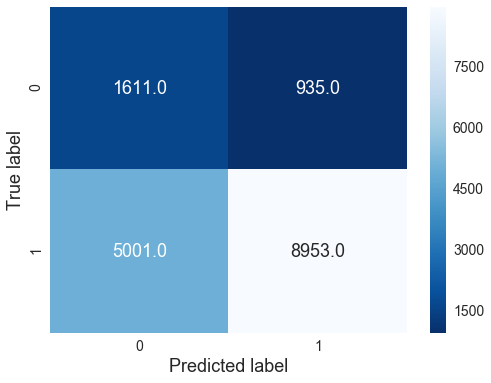

In [91]:
bestD = 5
bestN = 0.01

sn.set_style('whitegrid')

rocGB( xtr2, xte2, ytrain, ytest, bestD, bestN, 2 )

## Opeartions on Set 3

In [88]:
BestGB( xtr3, xcv3, ytrain, ycv )

             - First -                  - Second -                   - Third -                  - Fourth -
       ####################        ####################        ####################        ####################        

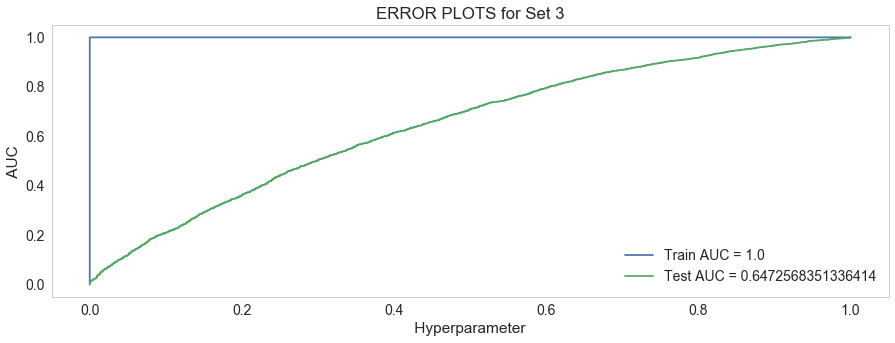

Confusion Matrix for Train of Set  3
 The maximum value of tpr*(1-fpr) =  1.0  for threshold =  0.999
[[ 3463     0]
 [18981     1]]


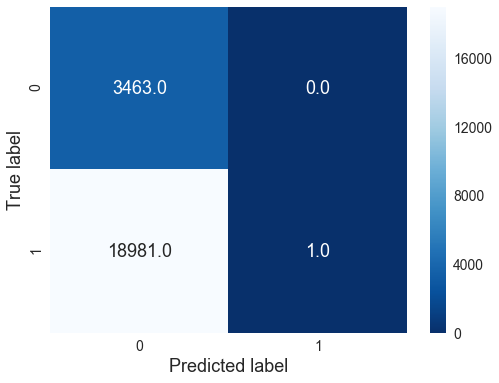



Confusion Matrix for Test  3
 The maximum value of tpr*(1-fpr) =  0.36910118545718784  for threshold =  0.964
[[1489 1057]
 [5248 8706]]


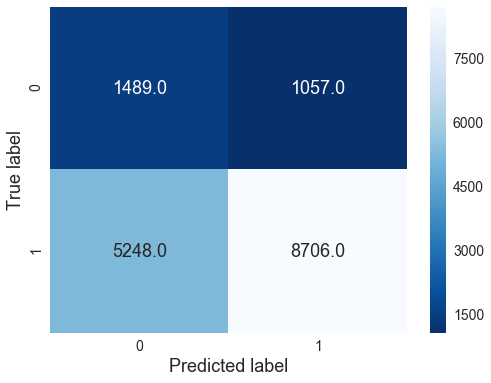

In [92]:
bestD = 51
bestN = 0.01
sn.set_style('whitegrid')

rocGB( xtr3, xte3, ytrain, ytest, bestD, bestN, 3 )

## Opeartions on Set 4

In [89]:
BestGB( xtr4, xcv4, ytrain, ycv )

             - First -                  - Second -                   - Third -                  - Fourth -
       ####################        ####################        ####################        ####################        

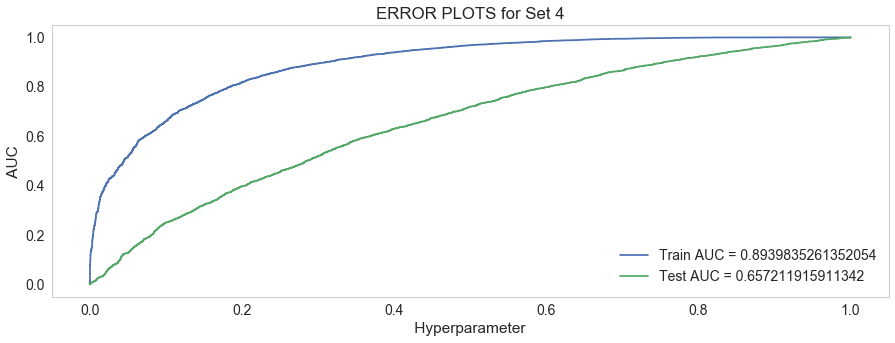

Confusion Matrix for Train of Set  4
 The maximum value of tpr*(1-fpr) =  0.6563316834986277  for threshold =  0.838
[[ 2946   517]
 [ 4790 14192]]


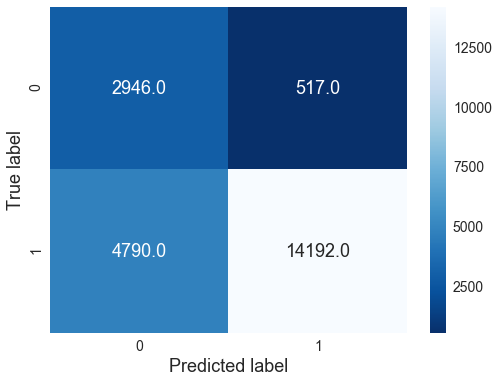



Confusion Matrix for Test  4
 The maximum value of tpr*(1-fpr) =  0.3808413087958967  for threshold =  0.846
[[1486 1060]
 [5023 8931]]


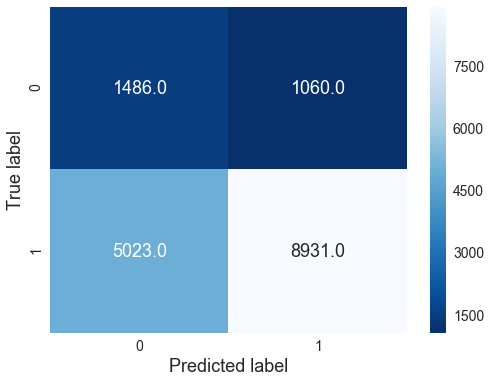

In [93]:
bestD = 5
bestN = 0.01

sn.set_style('whitegrid')

rocGB( xtr4, xte4, ytrain, ytest, bestD, bestN, 4 )

In [95]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = [" Classifier "," Set "," Vectorizer ", " Best Depth ", " Best Learning Rate ", " Train AUC ", " Test AUC "]

x.add_row( [ " XG Boost ", " Set 1 ", " B.O.W ", " 11 ", " 0.01 ", " 0.9997 ", " 0.6833 " ] ) 
x.add_row( [ " XG Boost ", " Set 2 ", " TFIDF ", " 5 ", " 0.01 ", " 9292 ", " 0.6866 " ] )
x.add_row( [ " XG Boost ", " Set 3 ", " Avg W2V ", " 51 ", " 0.01 ", " 1.0 ", " 0.6472 " ] )
x.add_row( [ " XG Boost ", " Set 4 ", " WW2V ", " 5 ", " 0.01 ", " 8639 ", " 0.6572 " ] )


print('\n\t\t\t Results of XG Boost model')
print( x )

# Ref : http://zetcode.com/python/prettytable/


			 Results of XG Boost model
+--------------+---------+--------------+--------------+----------------------+-------------+------------+
|  Classifier  |   Set   |  Vectorizer  |  Best Depth  |  Best Learning Rate  |  Train AUC  |  Test AUC  |
+--------------+---------+--------------+--------------+----------------------+-------------+------------+
|   XG Boost   |  Set 1  |    B.O.W     |      11      |         0.01         |    0.9997   |   0.6833   |
|   XG Boost   |  Set 2  |    TFIDF     |      5       |         0.01         |     9292    |   0.6866   |
|   XG Boost   |  Set 3  |   Avg W2V    |      51      |         0.01         |     1.0     |   0.6472   |
|   XG Boost   |  Set 4  |     WW2V     |      5       |         0.01         |     8639    |   0.6572   |
+--------------+---------+--------------+--------------+----------------------+-------------+------------+


## Conclusions


In [98]:
from prettytable import PrettyTable
    
x = PrettyTable()
y = PrettyTable()


x.field_names = [" Classifier "," Set "," Vectorizer ", " Best Depth ", " Best Learning Rate ", " Train AUC ", " Test AUC "]

x.add_row( [ " XG Boost ", " Set 1 ", " B.O.W ", " 11 ", " 0.01 ", " 0.9997 ", " 0.6833 " ] ) 
x.add_row( [ " XG Boost ", " Set 2 ", " TFIDF ", " 5 ", " 0.01 ", " 0.9292 ", " 0.6866 " ] )
x.add_row( [ " XG Boost ", " Set 3 ", " Avg W2V ", " 51 ", " 0.01 ", " 1.0 ", " 0.6472 " ] )
x.add_row( [ " XG Boost ", " Set 4 ", " WW2V ", " 5 ", " 0.01 ", " 0.8639 ", " 0.6572 " ] )

y.field_names = [" Classifier "," Set "," Vectorizer ", " Best Depth ", " Best Estimator ", " Train AUC ", " Test AUC "]

y.add_row( [ " Random Forest ", " Set 1 ", " B.O.W ", " 11 ", " 200 ", " 0.9215 ", " 0.6691 " ] ) 
y.add_row( [ " Random Forest ", " Set 2 ", " TFIDF ", " 11 ", " 200 ", " 0.9213 ", " 0.6587 " ] )
y.add_row( [ " Random Forest ", " Set 3 ", " Avg W2V ", " 101 ", " 100 ", " 1.0 ", " 0.6290 " ] )
y.add_row( [ " Random Forest ", " Set 4 ", " WW2V ", " 5 ", " 100 ", " 0.9914 ", " 0.5580 " ] )

print( x )
print()
print( y )
# Ref : http://zetcode.com/python/prettytable/

+--------------+---------+--------------+--------------+----------------------+-------------+------------+
|  Classifier  |   Set   |  Vectorizer  |  Best Depth  |  Best Learning Rate  |  Train AUC  |  Test AUC  |
+--------------+---------+--------------+--------------+----------------------+-------------+------------+
|   XG Boost   |  Set 1  |    B.O.W     |      11      |         0.01         |    0.9997   |   0.6833   |
|   XG Boost   |  Set 2  |    TFIDF     |      5       |         0.01         |    0.9292   |   0.6866   |
|   XG Boost   |  Set 3  |   Avg W2V    |      51      |         0.01         |     1.0     |   0.6472   |
|   XG Boost   |  Set 4  |     WW2V     |      5       |         0.01         |    0.8639   |   0.6572   |
+--------------+---------+--------------+--------------+----------------------+-------------+------------+

+-----------------+---------+--------------+--------------+------------------+-------------+------------+
|    Classifier   |   Set   |  Vector


The Best Overall model is XG Boost on TFIDF vectorized dataset

In both XG Boost and Random Forest models Avg word 2 Vec vectorizer provides highest Test AUC among all others

TFIDF with XG Boost has the highest Test AUC

TFIDF and BOW approach produce almost the same Test AUC

XG Boost models prove much effective than Random Forest in this case